# Run a Binary/Multiclass Classification Experiment with Cross-Validation

We are interested in extracting which features are necessarily important in the problem of separating out epilepsy from non-epilepsy scalp EEGs. We approach this problem from the lens of a statistical data science problem. 

We are given some relatively high-dimensional data over space and time for EEG, and are tasked with determining what properties of the data help a statistical algorithm consistently and robustly predict epilepsy and non-epilepsy.

We can guide the problem's statistics in several ways:

    - engineering of the features, X matrix
    - engineering of the y labels, y vector
    
Engineering the X matrix features can involve encoding certain priors of the data. For example, one might assume spatial information is important.

Engineering the y labels can involve different experimental design. Whether that is assuming that epilepsy normal EEGs are similar with epilepsy abnormal EEGs in feature space.

## To Add New Features

I implemented the `load_derived_datasets` and `get_X_features` functions inside episcalp, which handle loading datasets that are stored in BIDS derivative layout and then transforming those datasets into a feature matrix, X, for input into a classification task.

`Load_derived_datasets` just requires one to define a new reading function similar to how I've done for fragility and tfrs. Spikes are loaded in directly from the raw dataset using `_compute_spike_rates`. 

To try different features, one just needs to modify `get_X_features`.

In [2]:
%load_ext lab_black

In [225]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys
from numpy import interp
from pprint import pprint

from numpy.testing import assert_array_equal

warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.scripts.spikes.summary import _get_spike_annots
from episcalp.cross_validate import (
    get_X_features,
    load_derived_datasets,
    _compute_spike_rates,
)
from episcalp.preprocess.montage import _standard_lobes
from episcalp.utils.utils import NumpyEncoder

# if you installed sporf via README
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# this should be at least 1.0
print(sklearn.__version__)

1.1.dev0


In [5]:
y_enc = LabelEncoder()
y_enc = LabelBinarizer()

In [6]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [7]:
def convert_experimental_cond_to_y(experimental_condition_list):
    """Encoder for y labels."""
    # Group name keys, assigned y-label values
    experimental_condition_map = {
        "non-epilepsy-normal-eeg": 0,
        "epilepsy-normal-eeg": 1,
        "epilepsy-abnormal-eeg": 2,
    }
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

# Define possible helper functions

In [8]:
def _preprocess_epochs_tfr(data):
    """Turn TFR data into a 2D array."""
    assert data.ndim == 4

    # take the average over frequencies
    data = np.mean(data, axis=2)

    # move the epoch ("window") axis to last
    data = np.moveaxis(data, 0, -2)

    # compress the time axis
    data = np.mean(data, axis=-1)

    # convert to dB
    data = 20 * np.log10(data)

    data = np.reshape(data, (data.shape[0], -1))
    return data

In [9]:
def _load_subject_derivs(deriv_path, read_func, subjects=None, search_str="*.npy"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)

    this_path = deriv_path
    while this_path.parent.name != "derivatives" and this_path.parent.name != "/":
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            deriv = read_func(fpath, source_check=False)

            # extract data
            ch_names = deriv.ch_names
            deriv_data = deriv.get_data()

            dataset["subject"].append(subject)
            dataset["data"].append(deriv_data)
            dataset["ch_names"].append(ch_names)
            dataset["roots"].append(root)

    return dataset

In [264]:
def _load_subject_tfrs(deriv_path, read_func, subjects=None, search_str="*.h5"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)

    this_path = deriv_path
    while this_path.parent.name != "derivatives" and this_path.parent.name != "/":
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            try:
                deriv = read_func(fpath)[0]
            except Exception as e:
                print(f"Failed trying to load {fpath}.")
                raise Exception(e)
            # extract data
            ch_names = deriv.ch_names
            deriv_data = deriv.data

            # apply mean across axis 2
            deriv_data = _preprocess_epochs_tfr(deriv_data)
            #             deriv_data = np.mean(deriv_data, axis=2)

            dataset["subject"].append(subject)
            dataset["data"].append(deriv_data)
            dataset["ch_names"].append(ch_names)
            dataset["roots"].append(root)

    return dataset

In [11]:
def _load_subject_spikes(root, subjects=None, search_str="*.edf"):
    if subjects is None:
        subjects = get_entity_vals(root, "subject")

    print(f"Loading data for subjects: {subjects}")

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = root / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.rglob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            entities = get_entities_from_fname(fpath.name)
            bids_path = BIDSPath(
                root=root, datatype="eeg", extension=".edf", **entities
            )
            raw = read_raw_bids(bids_path)

            # extract data
            ch_spike_rates = _compute_spike_rates(raw)

            # normalize spike counts
            for ch_name, val in ch_spike_rates.items():
                ch_spike_rates[ch_name] = val / (raw.n_times / raw.info["sfreq"])

            # total spike rate = total # of spikes regardless of channel / times / n_chs
            total_spike_rate = (
                np.sum(list(ch_spike_rates.values()))
                / len(raw.ch_names)
                / (raw.n_times / raw.info["sfreq"])
            )

            # max spike per lobe
            ch_spikes = np.array(list(ch_spike_rates.values()))
            lobe_dict = _standard_lobes(separate_hemispheres=False)

            # value of the max spike rate
            features = np.hstack(
                (
                    ch_spikes.mean(),
                    ch_spikes.std(),
                    np.quantile(ch_spikes, q=0.1),
                    np.quantile(ch_spikes, q=0.5),
                    np.quantile(ch_spikes, q=0.9),
                    total_spike_rate,
                )
            )
            ch_names = raw.ch_names

            assert len(ch_names) == len(ch_spike_rates.keys())
            assert_array_equal(ch_names, list(ch_spike_rates.keys()))

            dataset["data"].append(features)
            dataset["subject"].append(subject)
            dataset["ch_names"].append(ch_names)
            dataset["roots"].append(root)
    return dataset

# Define data directories

In [12]:
jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

# not ready yet
upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [13]:
reference = "monopolar"
radius = "1.25"

# define derivative chains
ss_deriv_chain = Path("sourcesink") / reference
frag_deriv_chain = Path("fragility") / f"radius{radius}" / reference

delta_tfr_deriv_chain = Path("tfr") / "delta"
theta_tfr_deriv_chain = Path("tfr") / "theta"
alpha_tfr_deriv_chain = Path("tfr") / "alpha"
beta_tfr_deriv_chain = Path("tfr") / "beta"

In [14]:
root = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

# Verify the number of derivatives per subject per feature

In [15]:
for deriv_chain, search_str in zip(
    [frag_deriv_chain, delta_tfr_deriv_chain], ["*desc-perturbmatrix*.npy", "*.h5"]
):
    num_datasets = dict()
    deriv_path = jeffroot / "derivatives" / deriv_chain

    subjects = get_entity_vals(deriv_path, "subject")
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        fpaths = list(subj_path.glob(search_str))
        num_datasets[subject] = len(fpaths)

    print(sum(num_datasets.values()))
    print(num_datasets)

33
{'jeff001': 2, 'jeff002': 1, 'jeff101': 2, 'jeff102': 5, 'jeff201': 6, 'jeff202': 5, 'jeff203': 2, 'jeff204': 1, 'jeff205': 1, 'jeff206': 1, 'jeff207': 1, 'jeff208': 4, 'jeff209': 1, 'jeff210': 1}
33
{'jeff001': 2, 'jeff002': 1, 'jeff101': 2, 'jeff102': 5, 'jeff201': 6, 'jeff202': 5, 'jeff203': 2, 'jeff204': 1, 'jeff205': 1, 'jeff206': 1, 'jeff207': 1, 'jeff208': 4, 'jeff209': 1, 'jeff210': 1}


# Load Feature Spatiotemporal Heatmap Datasets

In [18]:
exp_name = "fragilitylobes_jhhjeff"

In [28]:
roots = [jhroot, jeffroot]
deriv_chains = [frag_deriv_chain, frag_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = "*desc-perturbmatrix*.npy"

# load fragility dataset
fragility_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/fragility/radius1.25/monopolar
Loading 

In [15]:
roots = [jhroot, jeffroot]
deriv_chains = [frag_deriv_chain, frag_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = '*desc-perturbmatrix*.npy'

# load fragility dataset
fragility_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/fragility/radius1.25/monopolar
Loading 

(125, 5)


<AxesSubplot:>

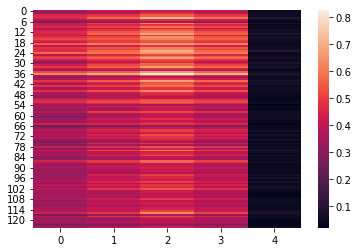

In [29]:
X_fragility = get_X_features(fragility_dataset, feature_name="data")

print(X_fragility.shape)

sns.heatmap(X_fragility)

## Load SS Heatmaps

In [31]:
roots = [jhroot, jeffroot]
deriv_chains = [ss_deriv_chain, ss_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = "*desc-ssindmatrix*.npy"

# load fragility dataset
ss_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/sourcesink/monopolar
Loading data for s

(125, 5)


<AxesSubplot:>

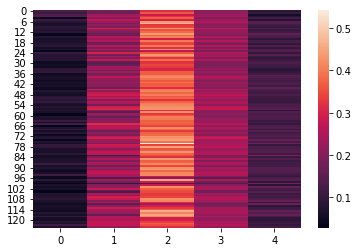

In [32]:
X_ss = get_X_features(ss_dataset, feature_name="data")
print(X_ss.shape)
sns.heatmap(X_ss)

## Load TFR Heatmaps

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/tfr/delta
Loading data for subjects: ['

<AxesSubplot:>

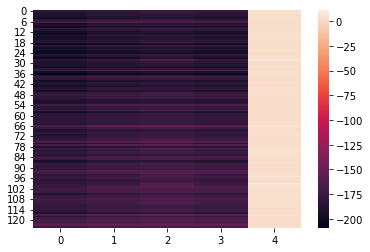

In [48]:
roots = [jhroot, jeffroot]
deriv_chains = [delta_tfr_deriv_chain, delta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
delta_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)

X_delta = get_X_features(delta_dataset, feature_name="data")
print(X_delta.shape)
sns.heatmap(X_delta)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/tfr/theta
Loading data for subjects: ['

<AxesSubplot:>

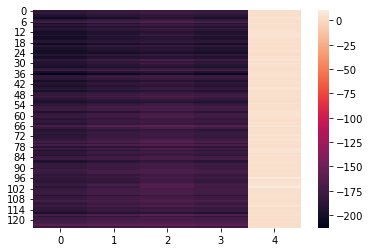

In [33]:
roots = [jhroot, jeffroot]
deriv_chains = [theta_tfr_deriv_chain, theta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
theta_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)

X_theta = get_X_features(theta_dataset, feature_name="data")
print(X_theta.shape)
sns.heatmap(X_theta)

In [34]:
roots = [jhroot, jeffroot]
deriv_chains = [alpha_tfr_deriv_chain, alpha_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
alpha_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)

X_alpha = get_X_features(alpha_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/tfr/alpha
Loading data for subjects: ['

In [266]:
roots = [jhroot, jeffroot]
deriv_chains = [beta_tfr_deriv_chain, beta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = "*.h5"

# load fragility dataset
beta_dataset = load_derived_datasets(
    roots,
    deriv_chains=deriv_chains,
    load_func=load_func,
    read_func=read_func,
    search_str=search_str,
)
X_beta = get_X_features(beta_dataset, feature_name="data")

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/tfr/beta
Loading data for subjects: ['j

## Load Spikes

In [267]:
def _convert_list_to_collection(deriv_dataset):
    # convert to a dictionary of lists
    derived_dataset = {key: [] for key in deriv_dataset[0].keys()}
    for deriv in deriv_dataset:
        for key in derived_dataset.keys():
            derived_dataset[key].extend(deriv[key])

    return derived_dataset


dataset_list = []
for root in roots:
    print("Getting spikes for", root)
    spike_dataset = _load_subject_spikes(root)
    dataset_list.append(spike_dataset)

print("Done...")
spikes_dataset = _convert_list_to_collection(dataset_list)

Getting spikes for /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids
Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']


ValueError: too many values to unpack (expected 2)

In [42]:
X_spikes = np.array(spikes_dataset["data"])
print(X_spikes.shape)

(125, 6)


# Creating Final Feature Matrix

## Optionally Join all/subset of Features

In [236]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [237]:
print(X_fragility.shape, X_delta.shape)

(125, 5) (125, 5)


(125, 31)


<AxesSubplot:>

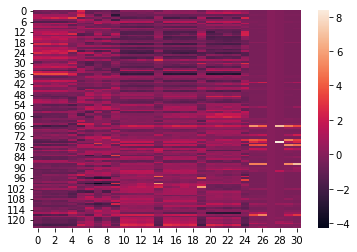

In [238]:
X = np.hstack(
    (
        X_fragility,
        X_ss,
        X_delta,
        X_theta,
        X_alpha,
        #                X_beta,
        X_spikes,
    )
)
print(X.shape)

sns.heatmap(scaler.fit_transform(X))

## Optionally Convert A Single Spatiotemporal Datasets Into Feature Matrix

In [168]:
print(fragility_dataset.keys())

dict_keys(['subject', 'data', 'ch_names', 'roots'])


(125, 5)


<AxesSubplot:>

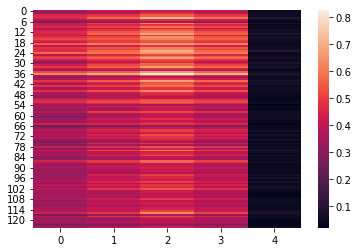

In [169]:
X = get_X_features(fragility_dataset, feature_name='data')

print(X.shape)

sns.heatmap(X)

# Creating the final set of labels

In [239]:
dataset = fragility_dataset

print(dataset.keys())
# get the y-labels
subjects = np.array(dataset["subject"])
roots = dataset["roots"]

exp_conditions = []
for subject, root in zip(subjects, roots):
    subj_df = _get_exp_condition(subject, root)
    exp_condition = subj_df["exp_condition"].values[0]
    exp_conditions.append(exp_condition)
print(np.unique(exp_conditions))

dict_keys(['subject', 'data', 'ch_names', 'roots'])
['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [240]:
y = y_enc.fit_transform(exp_conditions)
y_classes = y_enc.classes_
print(y_enc.classes_)
print(y.shape)

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']
(125, 3)


In [241]:
from numpy.testing import assert_array_equal

dataset = fragility_dataset
ch_names = dataset["ch_names"][0]
for idx, ch_names_ in enumerate(dataset["ch_names"]):
    try:
        assert_array_equal(ch_names, ch_names_)
    except Exception as e:
        print(dataset["subject"][idx])
#         raise Exception(e)
#         print(e)

print(ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6']


# Define Cross Validation Experiment

In [242]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [243]:
class BootstrapSplit:
    """A custom cross validator.

    This class is used to sample bootstraps of the
    dataset, which are just overlapping copies of
    X and y. All custom cross validators need
    to implement the ``get_n_splits`` and ``splits``
    function.
    """

    def __init__(self, n_splits, random_state):
        self.n_splits = n_splits
        self.random_state = random_state

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

    def split(self, X, y, group):
        n = X.shape[0]
        i = 1
        while i <= self.n_splits:
            orig_idx = np.arange(n)
            idx = self.random_state.choice(n, size=n, replace=True)

            # make sure the bootstrap samples contain at least
            # a sample from each class
            y_train_unique = np.unique(y[orig_idx])
            y_test_unique = np.unique(y[idx])
            if len(y_train_unique) == 1 or len(y_test_unique) == 1:
                continue
            yield idx, orig_idx
            i += 1

In [244]:
cv = StratifiedGroupKFold(
    n_splits=n_splits,
    random_state=random_state,
    shuffle=True,
)
cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)

cv = LeaveOneGroupOut()
# cv = BootstrapSplit(n_splits=100, random_state=random_state)

## Define Classification Models

In [245]:
random_state = 12345
clf_name = "sporf"
# clf_name = 'rf'
clf_name = "lr"
max_features = X.shape[1]

rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state,
    #                    "penalty": "l2"
}

In [246]:
if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)

# for multiclass
# clf = OneVsRestClassifier(clf)

clf = make_pipeline(
    #     StandardScaler(),
    clf
)
print(clf)
print(clf.steps)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=12345))])
[('logisticregression', LogisticRegression(n_jobs=-1, random_state=12345))]


# Subselect Data

Only consider say normal EEG category.

In [247]:
# find all indices of normal EEG
index = [idx for idx, cond in enumerate(exp_conditions) if "-normal-" in cond]

In [248]:
y = y_enc.fit_transform(exp_conditions)

y = y[index, :].argmax(axis=1) - 1
X_copy = X.copy()[index, :]
subjects = subjects[index]
y_classes = np.array([cond for cond in y_classes if "-normal-" in cond])

print(y.shape, X_copy.shape, X.shape)
print(np.unique(y))

(72,) (72, 31) (125, 31)
[0 1]


In [249]:
X = X_copy

print(y.shape, X_copy.shape, X.shape)

(72,) (72, 31) (72, 31)


# Run Recursive Feature Selection

In [250]:
from sklearn.feature_selection import RFECV, RFE
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [251]:
feature_vec_names = np.hstack(
    [
        f"{feat_name}_q0.1",
        f"{feat_name}_q0.5",
        f"{feat_name}_q0.9",
        f"{feat_name}_mean",
        f"{feat_name}_std",
    ]
    for feat_name in [
        "fragility",
        "ss",
        "delta",
        "theta",
        "alpha",
        #                       "beta"
    ]
)

feature_vec_names = feature_vec_names.tolist() + [
    "spike_mean",
    "spike_std",
    "spike_q0.1",
    "spike_q0.5",
    "spike_q0.9",
    "spike_total",
]
print(len(feature_vec_names))
print(X.shape)

print(feature_vec_names)

31
(72, 31)
['fragility_q0.1', 'fragility_q0.5', 'fragility_q0.9', 'fragility_mean', 'fragility_std', 'ss_q0.1', 'ss_q0.5', 'ss_q0.9', 'ss_mean', 'ss_std', 'delta_q0.1', 'delta_q0.5', 'delta_q0.9', 'delta_mean', 'delta_std', 'theta_q0.1', 'theta_q0.5', 'theta_q0.9', 'theta_mean', 'theta_std', 'alpha_q0.1', 'alpha_q0.5', 'alpha_q0.9', 'alpha_mean', 'alpha_std', 'spike_mean', 'spike_std', 'spike_q0.1', 'spike_q0.5', 'spike_q0.9', 'spike_total']


In [201]:
# y_classes

# # remove abnormal EEG class
# abnorm_idx = 0
# y_keep_idx = np.argwhere(y != abnorm_idx).squeeze()
# y_rfe = y[y_keep_idx]
# # y_rfe = y_rfe[:, 1:]
# X_rfe = X[y_keep_idx, :]

# print(y_rfe.shape, X_rfe.shape)

(35,) (35, 31)


<AxesSubplot:>

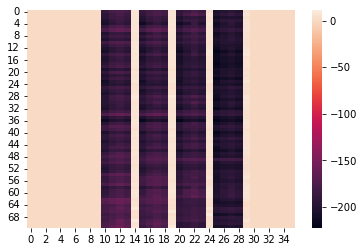

In [149]:
sns.heatmap(X_rfe)

In [252]:
selector = RFECV(
    clf,
    cv=cv,
    n_jobs=-1,
    min_features_to_select=5,
    importance_getter="named_steps.logisticregression.coef_",
    #     n_features_to_select=5,
)
# selector = EFS(clf, min_features=5,
#            max_features=5,
#            scoring='roc_auc',
#            print_progress=False,
#            cv=None)

selector = selector.fit(X, y, groups=subjects)

/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adam2392/Documents/scikit-learn/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
# exhausive w ss, no beta, no cv
print(list(selector.best_idx_))
print(selector.best_feature_names_)
print(np.array(feature_vec_names)[list(selector.best_idx_)])

In [253]:
# recursive w ss, LOGout cv and w/o beta
print(selector.ranking_)
print(selector.support_)
best_index = [idx for idx, rnk in enumerate(selector.ranking_) if rnk == 1]
print(best_index)
print(np.array(feature_vec_names)[best_index])
print(
    f"Features selected through recursive feature elimination: ",
    np.array(feature_vec_names)[selector.support_],
)

[ 8  1  1  2 16 10 17 14 20 13  1  7  1 21  1  6 11 18  9  1  4 12  5 15
  3 22 19 26 24 23 25]
[False  True  True False False False False False False False  True False
  True False  True False False False False  True False False False False
 False False False False False False False]
[1, 2, 10, 12, 14, 19]
['fragility_q0.5' 'fragility_q0.9' 'delta_q0.1' 'delta_q0.9' 'delta_std'
 'theta_std']
Features selected through recursive feature elimination:  ['fragility_q0.5' 'fragility_q0.9' 'delta_q0.1' 'delta_q0.9' 'delta_std'
 'theta_std']


In [215]:
# recursive w ss, cv and w/o beta
print(selector.ranking_)
print(selector.support_)
best_index = [idx for idx, rnk in enumerate(selector.ranking_) if rnk == 1]
print(best_index)
print(np.array(feature_vec_names)[best_index])
print(
    f"Features selected through recursive feature elimination: ",
    np.array(feature_vec_names)[selector.support_],
)

[ 9  2  1  3 17 11 18 15 21 14  1  8  1 22  1  7 12 19 10  1  5 13  6 16
  4 23 20 27 25 24 26]
[False False  True False False False False False False False  True False
  True False  True False False False False  True False False False False
 False False False False False False False]
[2, 10, 12, 14, 19]
['fragility_q0.9' 'delta_q0.1' 'delta_q0.9' 'delta_std' 'theta_std']
Features selected through recursive feature elimination:  ['fragility_q0.9' 'delta_q0.1' 'delta_q0.9' 'delta_std' 'theta_std']


In [162]:
# exhausive w ss, no cv
print(list(selector.best_idx_))
print(selector.best_feature_names_)
print(np.array(feature_vec_names)[list(selector.best_idx_)])

[5, 21, 29, 33]
('5', '21', '29', '33')
['ss_q0.1' 'alpha_q0.5' 'beta_std' 'spike_q0.5']


In [151]:
# w ss
print(selector.ranking_)
print(selector.support_)
print(np.array(feature_vec_names)[selector.support_])

[ 1  7 17 11  6  1  1  8  1  1  2  3 18 16  5  9  1 10  4  1  1  1  1  1
 14  1  1 12 13  1 15  1 19  1  1  1]
[ True False False False False  True  True False  True  True False False
 False False False False  True False False  True  True  True  True  True
 False  True  True False False  True False  True False  True  True  True]
['fragility_q0.1' 'ss_q0.1' 'ss_q0.5' 'ss_mean' 'ss_std' 'theta_q0.5'
 'theta_std' 'alpha_q0.1' 'alpha_q0.5' 'alpha_q0.9' 'alpha_mean'
 'beta_q0.1' 'beta_q0.5' 'beta_std' 'spike_std' 'spike_q0.5' 'spike_q0.9'
 'spike_total']


In [137]:
# w/o ss
print(selector.ranking_)
print(selector.support_)
print(np.array(feature_vec_names)[selector.support_])

[ 1  1 11 12  1 15  1 16  7  1 10  1 13  1  2  1  1  1  6  8  1  3  5  9
  1 14  1 17  1  1  4]
[ True  True False False  True False  True False False  True False  True
 False  True False  True  True  True False False  True False False False
  True False  True False  True  True False]
['fragility_q0.1' 'fragility_q0.5' 'fragility_std' 'delta_q0.5'
 'delta_std' 'theta_q0.5' 'theta_mean' 'alpha_q0.1' 'alpha_q0.5'
 'alpha_q0.9' 'beta_q0.1' 'beta_std' 'spike_std' 'spike_q0.5' 'spike_q0.9']


In [254]:
print(X.shape, y.shape)

# now sub-select the features
X = X[:, selector.support_]

print(X.shape, y.shape)

(72, 31) (72,)
(72, 6) (72,)


# Optionally Run on Entire Training Dataset

In [263]:
# fit on entire dataset
clf.fit(X, y)

scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_score,
    "cohen_kappa_score": cohen_kappa_score,
    "roc_auc": roc_auc_score,  #  "roc_auc",  # roc_auc_score,
    "f1": f1_score,
    "recall": recall_score,
    "specificity": recall_score,
    "precision": precision_score,
    "jaccard": jaccard_score,
    "average_precision": average_precision_score,
    "neg_brier_score": brier_score_loss,
    "cohen_kappa_score": cohen_kappa_score,
    #     'specificity': '',
}

# evaluate the model performance
scores = dict()
for score_name, score_func in scoring_funcs.items():
    y_pred_proba = clf.predict_proba(X)
    if score_name == "specificity":
        score_func = make_scorer(score_func, pos_label=0)
    else:
        score_func = make_scorer(score_func)
    score = score_func(clf, X, y)

    scores[score_name] = score

for idx in np.unique(y):
    print(f"Class {idx} has ", len(np.argwhere(y == idx)))
y_pred = clf.predict(X)
print(precision_recall_fscore_support(y, y_pred, average="macro"))
pprint(scores)

Class 0 has  37
Class 1 has  35
(0.6671814671814672, 0.6671814671814672, 0.6666666666666667, None)
{'average_precision': 0.5975654225654226,
 'balanced_accuracy': 0.6671814671814672,
 'cohen_kappa_score': 0.33384734001542027,
 'f1': 0.6666666666666667,
 'jaccard': 0.5,
 'neg_brier_score': 0.3333333333333333,
 'precision': 0.6486486486486487,
 'recall': 0.6857142857142857,
 'roc_auc': 0.6671814671814673,
 'specificity': 0.6486486486486487}


# Run sklearn.cross_validate

In [161]:
print(X.shape, y.shape)
print(clf)

(72, 31) (72,)
Pipeline(steps=[('obliqueforestclassifier',
                 ObliqueForestClassifier(max_features=31, n_estimators=1000,
                                         n_jobs=-1, random_state=12345))])


In [162]:
scoring_funcs = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "cohen_kappa_score": make_scorer(cohen_kappa_score),
    "roc_auc": "roc_auc",  # roc_auc_score,
    "f1": "f1",  # f1_score,
    "recall": "recall",  # makerecall_score,
    "precision": "precision",  # precision_score,
    "jaccard": "jaccard",  # jaccard_score,
    "average_precision": "average_precision",  # average_precision_score,
    "neg_brier_score": "neg_brier_score",  # brier_score_loss,
}

# define multiclass cross_validation scoring metrics
f1_micro = lambda x: make_scorer(f1_score, average="micro")
recall_micro = lambda x: make_scorer(recall_score, average="micro")
precision_micro = lambda x: make_scorer(precision_score, average="micro")
jaccard_micro = lambda x: make_scorer(jaccard_score, average="micro")
roc_ovr = lambda x: make_scorer(roc_auc_score, multi_class="ovr")

# some scorers need to get defined with this for multiclass
def cohen_scorer(clf, X, y):
    y_pred = clf.predict(X).argmax(axis=1)
    y = y.argmax(axis=1)
    return cohen_kappa_score(y, y_pred)


def balanced_accuracy_scorer(clf, X, y):
    y_pred = clf.predict(X).argmax(axis=1)
    y = y.argmax(axis=1)
    return balanced_accuracy_score(y, y_pred)


multiclass_scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_scorer,
    "cohen_kappa_score": cohen_scorer,
    "roc_auc_ovr": "roc_auc_ovr",  # roc_ovr,
    "f1_micro": "f1_micro",  # f1_micro,
    "recall_micro": "recall_micro",
    "precision_micro": "precision_micro",
    "jaccard_micro": "jaccard_micro",
}

if len(np.unique(y_classes)) == 2:
    scoring = scoring_funcs
else:
    scoring = multiclass_scoring_funcs

print(scoring)

{'balanced_accuracy': make_scorer(balanced_accuracy_score), 'cohen_kappa_score': make_scorer(cohen_kappa_score), 'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'jaccard': 'jaccard', 'average_precision': 'average_precision', 'neg_brier_score': 'neg_brier_score'}


In [163]:
# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=subjects,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    return_train_score=True,
    n_jobs=-1,
    error_score="raise",
)

# get the estimators
estimators = scores.pop("estimator")

## Optionally Correct for Optimism Using Bootstrap

In [ ]:
# Now calculate the optimism as the average of the AUC over
# the bootstrap samples.
mean_optimism = np.mean(scores["train_score"] - scores["test_score"])
std_optimism = np.std(scores["train_score"] - scores["test_score"])
print(f"Optimism is {mean_optimism} +/- {std_optimism}")

# Now calculate the optimism adjusted AUC metric.
adjusted_auc = auc_est - mean_optimism
print(f"The AUC computed by bootstrapping and adjusting for optimism: {adjusted_auc}")

In [164]:
print(scores["test_f1"])
print(X.shape, y.shape)
print(y_classes)
print(np.unique(y_classes))

[0.54545455 0.47619048 0.64285714 0.6        0.58333333 0.57142857
 0.44444444 0.66666667 0.64       0.73684211 0.54545455 0.72727273
 0.52173913 0.43478261 0.56       0.57142857 0.57142857 0.69565217
 0.58823529 0.4       ]
(72, 31) (72,)
['epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']
['epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [165]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
    "test_y",
    "test_y_encodings",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_y"].append(y[test_inds])
    #     scores["test_y_encodings"].append(y_encode[test_inds])

    # evaluate on the train set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob = estimator.predict_proba(X_train)
    y_pred_label = np.argmax(y_pred_prob, axis=1)

    # compute calibration curve
    if len(np.unique(y_classes)) == 2:
        if y_pred_prob.ndim == 2:
            y_pred_prob = y_pred_prob[:, -1]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_train, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["train_fraction_pos"].append(fraction_of_positives)
        scores["train_mean_pred_value"].append(mean_predicted_value)

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y_classes)) == 2:
        fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
        scores["train_fpr"].append(fpr)
        scores["train_tpr"].append(tpr)
        scores["train_fnr"].append(fnr)
        scores["train_tnr"].append(tnr)
        scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)
    y_pred_label = np.argmax(y_pred_prob, axis=1)

    # compute calibration curve
    if len(np.unique(y_classes)) == 2:
        if y_pred_prob.ndim == 2:
            y_pred_prob = y_pred_prob[:, -1]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["test_fraction_pos"].append(fraction_of_positives)
        scores["test_mean_pred_value"].append(mean_predicted_value)

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y_classes)) == 2:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
        scores["test_fpr"].append(fpr)
        scores["test_tpr"].append(tpr)
        scores["test_fnr"].append(fnr)
        scores["test_tnr"].append(tnr)
        scores["test_thresholds"].append(thresholds)

    if y_test.ndim == 2:
        y_test_ = y_test.astype(int).argmax(axis=1)
    else:
        y_test_ = y_test.astype(int)
    conf_matrix = confusion_matrix(y_test_, (y_pred_label).astype(int))
    if len(np.unique(y_classes)) == 2:
        tn, fp, fn, tp = conf_matrix.ravel()
        scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator,
        X_test,
        y_test,
        n_repeats=5,
        random_state=random_state,
        n_jobs=-1,
        scoring="roc_auc_ovr",
    )
    scores["test_importances"].append(r.importances)

Using estimator  Pipeline(steps=[('obliqueforestclassifier',
                 ObliqueForestClassifier(max_features=31, n_estimators=1000,
                                         n_jobs=-1, random_state=12345))])


In [167]:
# add metadata
scores["y_classes"] = y_classes

## Save Model Output Scores

In [168]:
fname = (
    deriv_root.parent
    / "derivatives"
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_{exp_name}_withstd.json"
)
print(fname)

/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv20_sporf_mtry31_fragilitylobes_jhhjeff_withstd.json


In [68]:
with open(fname.with_suffix(".json"), "w") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)

# Run Basic Model Plotting

In [169]:
meta_df = pd.DataFrame()
for root in [jhroot, jeffroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,outcome,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN


In [170]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc', 'train_roc_auc', 'test_f1', 'train_f1', 'test_recall', 'train_recall', 'test_precision', 'train_precision', 'test_jaccard', 'train_jaccard', 'test_average_precision', 'train_average_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings', 'y_classes'])


## ROC Curves

In [173]:
def _interp_roc(fpr, tpr):
    mean_fpr = np.linspace(0, 1, 100)

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return interp_tpr, mean_fpr

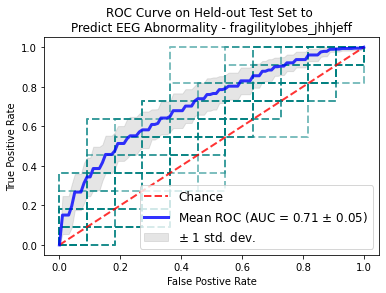

In [174]:
which_set = "test"
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
# fig.savefig(figure_dir / f"roc_curve_{exp_name}.pdf", bbox_inches="tight")

## Multiclass Classification ROC Set up

In [71]:
y_classes = scores["y_classes"]

print(y_classes)

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [76]:
y_proba = scores["test_y_pred_proba"]
y_true = scores["test_y"]

n_classes = len(np.unique(y_classes))

# construct mean/std ROC curves
fpr = collections.defaultdict(list)
tpr = collections.defaultdict(list)
roc_auc = collections.defaultdict(list)

for idx in range(n_splits):
    y_test = np.array(y_true[idx])
    y_score = np.array(y_proba[idx])

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr_, tpr_, _ = roc_curve(y_test[:, i], y_score[:, i])
        tpr_, fpr_ = _interp_roc(fpr_, tpr_)
        fpr[i].append(fpr_)
        tpr[i].append(tpr_)

        roc_auc[i].append(auc(fpr[i][idx], tpr[i][idx]))

    # Compute micro-average ROC curve and ROC area
    fpr_, tpr_, _ = roc_curve(y_test.ravel(), y_score.ravel())
    tpr_, fpr_ = _interp_roc(fpr_, tpr_)
    fpr["micro"].append(fpr_)
    tpr["micro"].append(tpr_)
    roc_auc["micro"].append(auc(fpr["micro"][idx], tpr["micro"][idx]))

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i][idx] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i][idx], tpr[i][idx])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"].append(all_fpr)
    tpr["macro"].append(mean_tpr)
    roc_auc["macro"].append(auc(fpr["macro"][idx], tpr["macro"][idx]))

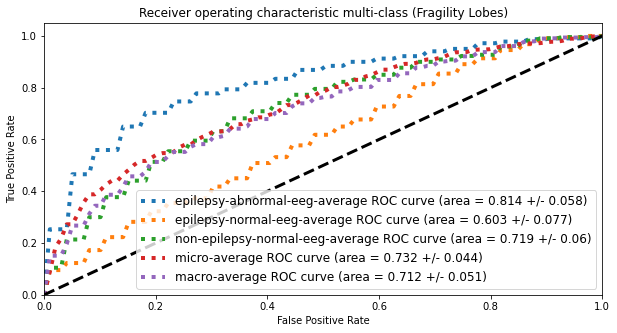

In [77]:
keys = np.unique(np.array(y_true[0]).argmax(axis=1)).tolist() + ["micro", "macro"]

fig, ax = plt.subplots(figsize=(10, 5))
lw = 3
for key in keys:
    mean_fpr = np.mean(fpr[key], axis=0)

    # compute the mean and std TPR
    mean_tpr = tpr[key]
    mean_tpr = np.mean(tpr[key], axis=0)
    mean_tpr[-1] = 1.0

    std_tpr = np.std(tpr[key], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    # compute the AUCS mean +/- std
    aucs = roc_auc[key]
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    # Plot all ROC curves
    if key in range(n_classes):
        key = y_classes[int(key)]
    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"{key}-average ROC curve (area = {mean_auc.round(3)} +/- {std_auc.round(3)})",
        #          color='deeppink',
        linestyle=":",
        linewidth=4,
    )

# ax.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

ax.plot([0, 1], [0, 1], "k--", lw=lw)
ax.set(
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver operating characteristic multi-class (Fragility Lobes)",
)
ax.legend(loc="lower right", fontsize=12)
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
plt.show()

# Boxplot of Metrics

In [178]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc', 'train_roc_auc', 'test_f1', 'train_f1', 'test_recall', 'train_recall', 'test_precision', 'train_precision', 'test_jaccard', 'train_jaccard', 'test_average_precision', 'train_average_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings', 'y_classes'])


In [179]:
extra_str = "_micro"
extra_str = ""
roc_str = f"test_roc_auc_ovr"
roc_str = f"test_roc_auc"

metrics = [
    f"test_f1{extra_str}",
    f"test_recall{extra_str}",
    f"test_precision{extra_str}",
    roc_str,
    f"test_balanced_accuracy",
    f"test_cohen_kappa_score",
]

df = pd.DataFrame()
for metric in metrics:
    metric_scores = scores[metric]
    df[metric] = metric_scores

df = pd.melt(df, value_name="value", var_name="metric")

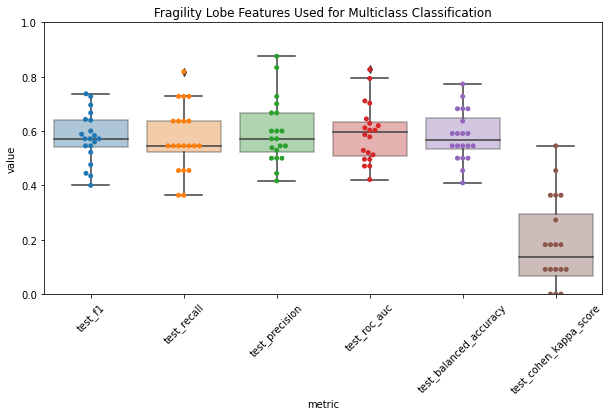

In [180]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    x="metric",
    y="value",
    #     color="gray",
    data=df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="metric",
    y="value",
    #     hue="exp_condition",
    #               color="black",
    data=df,
    ax=ax,
)
ax.set(
    ylim=[0, 1],
    title="Fragility Lobe Features Used for Multiclass Classification",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# ax.axhline(0.5, label="chance")
fig.patch.set_facecolor("white")

## Plotting Predicted Probability of Success Scores

In [200]:
print(y_classes.index("non-epilepsy-normal-eeg"))
print(y_classes)

2
['epilepsy-abnormal-eeg', 'epilepsy-normal-eeg', 'non-epilepsy-normal-eeg']


In [207]:
# TODO: modify to fit the participants framework
y_probas_epiabnorm = []
y_probas_epinorm = []
y_probas_nonepi = []
subj_list = []
folds = []

# experimental condition
exp_conditions = []
y_outcomes = []
centers = []
num_aeds = []
final_diagnosis = []
epilepsy_types = []
epilepsy_hemisphere = []
epilepsy_lobe = []

# create dataframe over the entire cross validation
for idx in range(n_splits):
    y_pred_proba = np.array(scores[f"{which_set}_y_pred_proba"][idx])
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    y_true = np.array(scores["test_y"][idx]).argmax(axis=1)

    for subject in cv_subjects:
        # extract column data for each subject
        outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "exp_condition"
        ].values[0]
        aeds = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "num_aeds"
        ].values[0]
        diagnosis = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "final_diagnosis"
        ].values[0]
        epi_type = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_type"
        ].values[0]
        epi_hemisphere = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_hemisphere"
        ].values[0]
        epi_lobe = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_lobe"
        ].values[0]

        # this should match the original
        #         if outcome.startswith("epilepsy"):
        #             y_outcome = "epilepsy"
        #         else:
        #             y_outcome = outcome
        #         y_outcomes.append(y_outcome)
        exp_conditions.append(outcome)
        num_aeds.append(aeds)

        if subject.startswith("jhh"):
            center = "JHH"
        elif subject.startswith("jeff"):
            center = "Jefferson"
        elif subject.startswith("upmc"):
            center = "UPMC"
        centers.append(center)

    y_outcomes.extend([y_classes[idx] for idx in y_true])
    y_pred_proba_epiabnorm = y_pred_proba[:, y_classes.index("epilepsy-abnormal-eeg")]
    y_pred_proba_epinorm = y_pred_proba[:, y_classes.index("epilepsy-normal-eeg")]
    y_pred_proba_nonepi = y_pred_proba[:, y_classes.index("non-epilepsy-normal-eeg")]

    y_probas_epiabnorm.extend(y_pred_proba_epiabnorm)
    y_probas_epinorm.extend(y_pred_proba_epinorm)
    y_probas_nonepi.extend(y_pred_proba_nonepi)

    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [211]:
proba_df = pd.DataFrame(
    (
        y_probas_epiabnorm,
        y_pred_proba_epinorm,
        y_pred_proba_nonepi,
        subj_list,
        exp_conditions,
        y_outcomes,
        centers,
        folds,
        num_aeds,
    )
).T
proba_df.columns = [
    "y_proba_abnorm",
    "y_proba_epinorm",
    "y_pred_proba_nonepi",
    "subject",
    "exp_condition",
    "outcome",
    "center",
    "fold",
    "num_aeds",
]

display(proba_df.head())

,y_proba_abnorm,y_proba_epinorm,y_pred_proba_nonepi,subject,exp_condition,outcome,center,fold,num_aeds
0,0.309513,0.412673,0.210414,jhh010,non-epilepsy-normal-eeg,non-epilepsy-normal-eeg,JHH,0,2.0
1,0.679438,0.263181,0.238247,jeff202,epilepsy-abnormal-eeg,epilepsy-abnormal-eeg,Jefferson,0,NaN
2,0.352238,0.224995,0.36901,jhh112,epilepsy-normal-eeg,epilepsy-normal-eeg,JHH,0,0.0
3,0.586641,0.400973,0.572252,jeff102,epilepsy-normal-eeg,epilepsy-normal-eeg,Jefferson,0,NaN
4,0.584036,0.49203,0.355397,jhh207,epilepsy-abnormal-eeg,epilepsy-abnormal-eeg,JHH,0,2.0


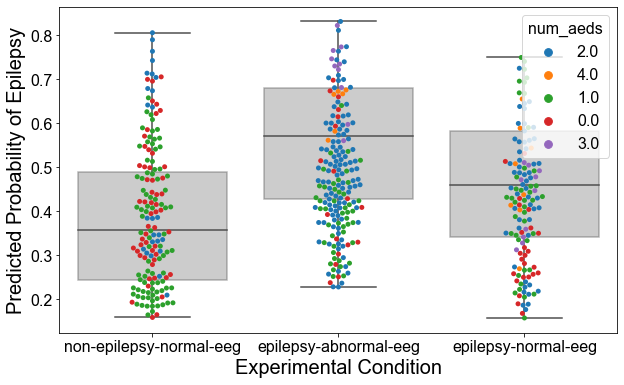

In [213]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="outcome",
    y="y_proba_abnorm",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="outcome",
    y="y_proba_abnorm",
    hue="num_aeds",
    #               color="black",
    data=proba_df,
    ax=ax,
)

ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Experimental Condition",
)
fig.patch.set_facecolor("white")

# fig.savefig(figure_dir / f"{exp_name}_y_pred_proba_surgical_outcomes.pdf", bbox_inches="tight")